In [30]:
# IMPORT LIBS
import cellxgene_census
import cellxgene_census.experimental.ml as census_ml
import numpy as np
import numpy.typing as npt
import tiledbsoma as soma
import torch
import zarr
from typing import Literal
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


In [57]:
# DEFINE UTIL FUNCIONS

# Make this function adaptable to other databases
def get_gene_set(
    atlas: str = "cellxgene",
    organism: str = "mus_musculus",
    max_size: None | int = None,
    version: str = "2025-01-30",
):
    if atlas == "cellxgene":
        with cellxgene_census.open_soma(census_version=version) as census:
            gene_metadata = cellxgene_census.get_var(
                census, 
                organism,
                column_names=["feature_name", "feature_id"])
            genes = gene_metadata['feature_name'].tolist()
        if max_size is None:
            return genes
        else:
            return genes[0:max_size]
    else:
        # Place holder for future data bases 
        raise ValueError(f"Unknown atlas: {atlas}")
    

# Make this function adaptable to other databases
def get_cell_set(
    atlas: str = "cellxgene",
    organism: str = "mus_musculus",
    max_size: None | int = None,
    version: str = "2025-01-30",
):
    if atlas == "cellxgene":
        with cellxgene_census.open_soma(census_version=version) as census:
            cell_meta_data = cellxgene_census.get_obs(
                census, organism, column_names=["cell_type"]
            )
            cell_types = list(set(cell_meta_data["cell_type"]))
        if max_size is None:
            return cell_types
        else:
            return cell_types[0:max_size]
    else:
        raise ValueError(f"Unknown atlas: {atlas}")
    
# For clarity and ease this one will be data base specific
# we can just write a wrapper for these later if needed.
def base_cellxgene(gene_set,
    cell_set,
    organism: str = "mus_musculus",
    batch_size: int = 1000,
    version: str = "2025-01-30",
    device: str = 'cpu'
):
    # Concat gene and cell set
    # always use primary data
    # User should always provide this data
    feature_set = "feature_name in ['" + "', '".join(gene_set) + "']"
    obs_set = "is_primary_data == True and cell_type in ['" + "', '".join(cell_set) + "']"
    
    # First we pull the data and use the pytorch loader.
    # So silly but at least we can GPU accelerate compute...
    with cellxgene_census.open_soma(census_version = version) as census:
        # get the minimal batch size
        query_size = cellxgene_census.get_obs(census,organism,value_filter=obs_set)
        effective_batch_size = min([batch_size, query_size.shape[0]])
        # get actual data to parse to experiment
        base_cell_data = census["census_data"][organism]
        # Check actual batch size - not the best but it will do for now
        obs_query = soma.AxisQuery(value_filter=obs_set)
        var_query = soma.AxisQuery(value_filter=feature_set)
                
        experiment_datapipe = census_ml.ExperimentDataPipe(
            base_cell_data,
            measurement_name="RNA",
            X_name="normalized",
            obs_query=obs_query,
            var_query=var_query,
            obs_column_names=["cell_type"],
            batch_size=effective_batch_size,
            shuffle=False)
        
        # Compute mean using torch
        experiment_dataloaded = census_ml.experiment_dataloader(experiment_datapipe)
        # will need to make a check here to add gpu
        device = torch.device(device)
        mean = 0.0
        var = 0.0
        batch_count = 1
        print(f'Number of batches = {len(experiment_dataloaded)}')
        for gene_tensor,_ in experiment_dataloaded:
            print(f'Processing batch {batch_count}')
            gene_tensor = gene_tensor.to(device)
            local_mean = torch.mean(gene_tensor, axis = 0)
            local_var = torch.var(gene_tensor, axis=0)
            mean += local_mean
            var += local_var
            total_mean = mean / batch_count
            total_mean = total_mean.detach().clone()
            total_var = var / batch_count
            total_var = total_var.detach().clone()
            batch_count += 1
    return total_mean.numpy(),total_var.numpy()

# Initialize store based on gene_set and cell set
def initialize_store(
    gene_set:int,
    cell_set:int,
    zarr_path: str | None = None,
    max_chunk_size: int = 10000,
):
    # define chunk size
    length_cell_set = len(cell_set)
    length_gene_set = len(gene_set)
    cell_chunk_size = min([max_chunk_size,length_cell_set])
    gene_chunk_size = min([max_chunk_size,length_gene_set])
    # Create the root zarr store
    if zarr_path is None:
        store = zarr.storage.MemoryStore()
    else:
        if Path(zarr_path).exists():
            print(f'{zarr_path} already exists - Skipping Store build')
            return zarr_path
        store = zarr.storage.LocalStore(zarr_path, read_only=False)
    root = zarr.create_group(store)
    
    # create base array for storing cell distances
    # Add a plus one to the cell set since we will store
    # the global cell average and each cell type average
    root.create_array("base_cell_mean",
                      shape = (length_cell_set + 1,length_gene_set),
                      dtype = np.float64,
                      chunks=(cell_chunk_size,gene_chunk_size),
                      fill_value=0.0)
    root.create_array("base_cell_var",
                      shape = (length_cell_set + 1,length_gene_set),
                      dtype = np.float64,
                      chunks=(cell_chunk_size,gene_chunk_size),
                      fill_value=0.0)
    cell_set = ["base_cell", *cell_set]
    root.create_array(name = "cell_id",
                         data = np.array(cell_set,dtype = str))
    root.create_array(name = "features",
                           data = np.array(gene_set, dtype = str))
    root.attrs["n_cells"] = length_cell_set
    root.attrs["n_features"] = length_gene_set
    
    return root

def get_base_cells(zarr_path,
    gene_set,
    cell_set,
    organism: str = "mus_musculus",
    batch_size: int = 1000,
    version: str = "2025-01-30",
    device: str = 'cpu'
):
    # First we get THE base cell
    # Not going to 
    base_mean,base_var = base_cellxgene(gene_set,
                               cell_set,
                               organism,
                               batch_size,
                               version,
                               device)
    # write the results to zarr store
    zarr_store = zarr.open(store = zarr_path,mode='r+')
    zarr_store['base_cell_mean'][0,:] = base_mean
    zarr_store['base_cell_var'][0,:] = base_var
    # Next we run over each cell types to get the mean cell of each cell type
    for ct in range(1,len(cell_set) + 1):
        cell_type = cell_set[ct-1]
        print(f'Current cell type = {cell_type}')
        local_mean,local_var = base_cellxgene(gene_set,
                               [cell_type],
                               organism,
                               batch_size,
                               version,
                               device)
        zarr_store['base_cell_mean'][ct,:] = local_mean
        zarr_store['base_cell_var'][ct,:] = local_var
    return zarr_store

def view_base_cells(zarr_path, modality: str = "base_cell_mean"):
    zarr_store = zarr.open(zarr_path, mode="r")

    mean_cells = zarr_store[modality][:]
    cell_types = zarr_store["cell_id"][:]
    features = zarr_store["features"][:]

    plt.figure(figsize=(10, 8))

    # Determine yticklabels based on the number of features
    if len(features) > 100:
        ytick_labels = False
    else:
        ytick_labels = features

    ax = sns.heatmap(
        mean_cells,
        cmap='viridis',
        xticklabels=cell_types,
        yticklabels=ytick_labels, # Use the determined value here
        annot=True
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # Set yticklabels rotation only if labels are present
    if ytick_labels is not False:
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.title("Heatmap of Zarr Array Data")
    plt.xlabel("Cell Types")
    plt.ylabel("Features")

    plt.show()


In [58]:
gene_set = get_gene_set()[0:1000]
cell_set = get_cell_set()[0:20]
store = initialize_store(gene_set,cell_set,"../data/base_cell.zarr")


/Users/martinp4/Documents/Cedars/esgaliant/esgaliant/.venv/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:249: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=47, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/Users/martinp4/Documents/Cedars/esgaliant/esgaliant/.venv/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:249: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=27, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type

In [ ]:

base_cells = get_base_cells("../data/base_cell.zarr",gene_set,cell_set,batch_size=10000)

/var/folders/jw/vhg8b9wx36zf9mhrvq504zgm0000gt/T/ipykernel_82340/1887276610.py:73: FutureWarning: cellxgene_census.experimental.ml.pytorch API will be removed in an upcoming release; upgrade to TileDB-SOMA-ML: https://github.com/single-cell-data/TileDB-SOMA-ML
  experiment_datapipe = census_ml.ExperimentDataPipe(
/var/folders/jw/vhg8b9wx36zf9mhrvq504zgm0000gt/T/ipykernel_82340/1887276610.py:84: FutureWarning: cellxgene_census.experimental.ml.pytorch API will be removed in an upcoming release; upgrade to TileDB-SOMA-ML: https://github.com/single-cell-data/TileDB-SOMA-ML
  experiment_dataloaded = census_ml.experiment_dataloader(experiment_datapipe)


Number of batches = 22
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4


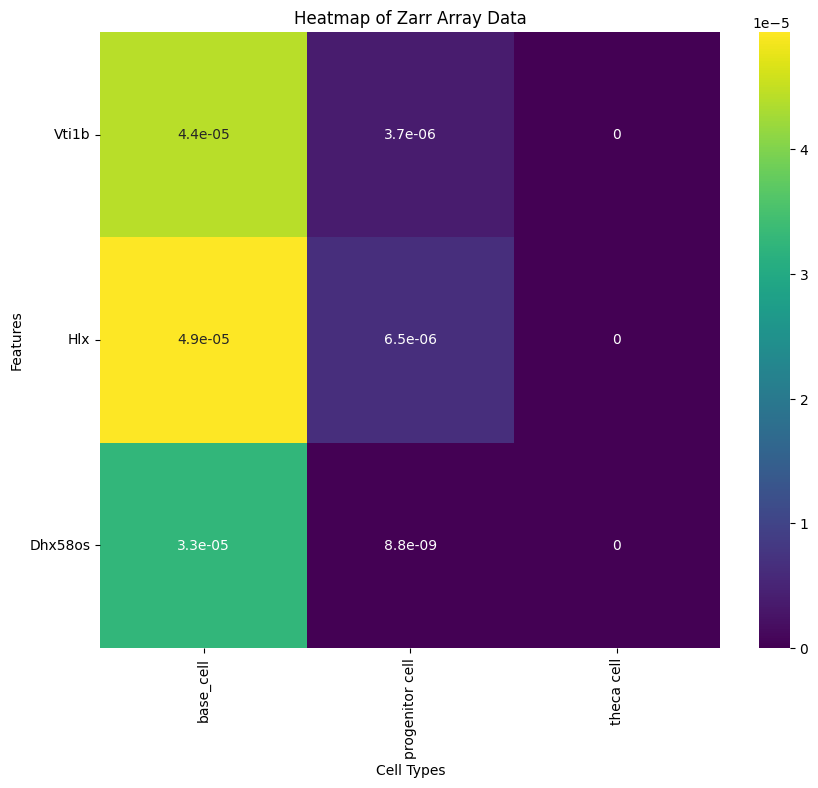

In [56]:
view_base_cells("../data/base_cell.zarr")